In [1]:
import os
import cv2
# import tensorflow as tf
import tensorflow as tf
import zipfile
import gdown

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available. Using CUDA.")
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
else:
    print("GPU is not available. Using CPU.")

# Google Drive file ID (Extracted from the given link)
file_id = "1KycQj4dik91RuBGvbhDJou7YDQEKAH2Z"

# Download destination
zip_path = "dataset.zip"

# Construct the Google Drive download URL
gdrive_url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(gdrive_url, zip_path, quiet=False)
extracted_folder = "dataset"
print("Extracting files...")
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extracted_folder)
print("Extraction complete.")

# Store the extracted path in a variable
dataset_path = os.path.abspath(extracted_folder)
print("Dataset available at:", dataset_path)

GPU is available. Using CUDA.


Downloading...
From (original): https://drive.google.com/uc?id=1KycQj4dik91RuBGvbhDJou7YDQEKAH2Z
From (redirected): https://drive.google.com/uc?id=1KycQj4dik91RuBGvbhDJou7YDQEKAH2Z&confirm=t&uuid=c98fdbc0-855f-4247-82be-f1395e8dcd82
To: /content/dataset.zip
100%|██████████| 2.25G/2.25G [00:30<00:00, 73.0MB/s]


Extracting files...
Extraction complete.
Dataset available at: /content/dataset


In [2]:
print(os.listdir(extracted_folder))

['MSFD']


In [3]:
class MSFDDataset:
    def __init__(self, dataset_path, img_size=(128, 128)):
        self.dataset_path = dataset_path

        # Get all face image files
        face_dir = os.path.join(dataset_path, "face_crop")
        segmentation_dir = os.path.join(dataset_path, "face_crop_segmentation")

        # Only include images that have corresponding segmentation files
        self.image_files = []
        self.segmentation_files = []

        for img_name in os.listdir(face_dir):
            seg_name = img_name  # Matching segmentation has the same filename

            img_path = os.path.join(face_dir, img_name)
            seg_path = os.path.join(segmentation_dir, seg_name)

            # Only include if both files exist
            if os.path.exists(img_path) and os.path.exists(seg_path):
                self.image_files.append(img_name)
                self.segmentation_files.append(seg_name)

        self.img_size = img_size
        print(f"Found {len(self.image_files)} matched image-segmentation pairs")

        # Define normalization transform as a TensorFlow layer
        self.img_transform = tf.keras.Sequential([
            tf.keras.layers.Resizing(img_size[0], img_size[1]),
            tf.keras.layers.Normalization(
                mean=[0.53, 0.457, 0.43],
                variance=[0.257**2, 0.239**2, 0.231**2]
            )
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and segmentation maps using OpenCV
        image_path = os.path.join(self.dataset_path, "face_crop", self.image_files[idx])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        segmentation_path = os.path.join(self.dataset_path, "face_crop_segmentation", self.segmentation_files[idx])
        segmentation = cv2.imread(segmentation_path, cv2.IMREAD_GRAYSCALE)

        # Resize
        image = cv2.resize(image, self.img_size)
        segmentation = cv2.resize(segmentation, self.img_size, interpolation=cv2.INTER_NEAREST)

        # Convert to tensors
        image = tf.convert_to_tensor(image, dtype=tf.float32) / 255.0
        segmentation = tf.convert_to_tensor(segmentation, dtype=tf.int32)

        # Apply normalization transform
        image = self.img_transform(image)

        return image, segmentation

In [4]:
dataset = MSFDDataset("/content/dataset/MSFD/1")

Found 9382 matched image-segmentation pairs


In [5]:
import numpy as np
dataset_size = len(dataset)
indices = np.arange(dataset_size)
np.random.shuffle(indices)

# Split indices
train_size = int(0.8 * dataset_size)
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Define a generator function for TensorFlow to load data from the dataset object
def data_generator(dataset_obj, indices):
    for idx in indices:
        image, segmentation = dataset_obj[idx]
        yield image, segmentation

# Create tf.data.Dataset objects from generators
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(dataset, train_indices),
    output_signature=(
        tf.TensorSpec(shape=(dataset.img_size[0], dataset.img_size[1], 3), dtype=tf.float32),
        tf.TensorSpec(shape=(dataset.img_size[0], dataset.img_size[1]), dtype=tf.int32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(dataset, val_indices),
    output_signature=(
        tf.TensorSpec(shape=(dataset.img_size[0], dataset.img_size[1], 3), dtype=tf.float32),
        tf.TensorSpec(shape=(dataset.img_size[0], dataset.img_size[1]), dtype=tf.int32)
    )
)

# Create data loaders (shuffle, batch, prefetch)
train_loader = train_dataset.shuffle(buffer_size=1000).batch(16).prefetch(tf.data.AUTOTUNE)
val_loader = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

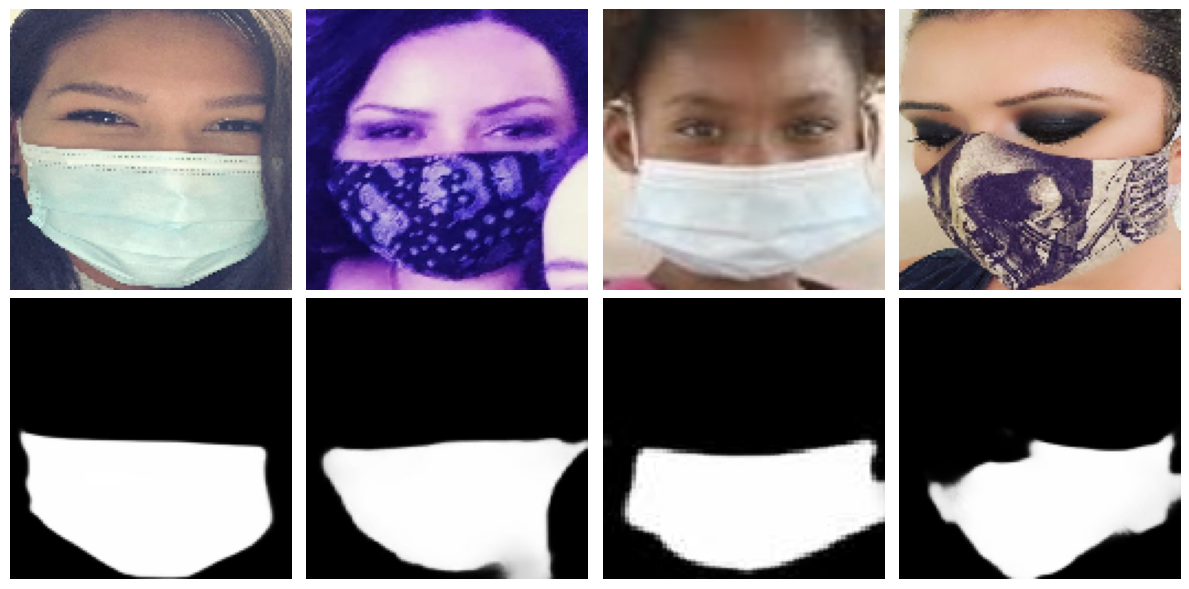

In [7]:
import matplotlib.pyplot as plt
def denormalize_images(images):
    # images shape: (batch, H, W, C)
    mean = tf.constant([0.53, 0.457, 0.43], dtype=tf.float32)
    std = tf.constant([0.257, 0.239, 0.231], dtype=tf.float32)
    return images * std + mean

def plot_images(images, segmentations):
    fig, axs = plt.subplots(2, 4, figsize=(12, 6))
    for i in range(4):
        axs[0, i].imshow(images[i].numpy())
        axs[0, i].axis('off')
        axs[1, i].imshow(segmentations[i].numpy(), cmap='gray')
        axs[1, i].axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch from train_loader
for images, segmentations in train_loader.take(1):
    # Denormalize
    images = denormalize_images(images)
    plot_images(images, segmentations)


In [8]:
image_paths = os.listdir("/content/dataset/MSFD/1/face_crop")
ground_truths = os.listdir("/content/dataset/MSFD/1/face_crop_segmentation")

In [9]:
if os.path.exists("PartC"):
    for file in os.listdir("PartC"):
        file_path = os.path.join("PartC", file)
        if os.path.isfile(file_path):
            os.unlink(file_path)
else:
    os.makedirs("PartC")

In [10]:
def evaluate(segment, ground_truth):
    intersection = ((segment > 0) & (ground_truth > 0)).sum()
    union = ((segment > 0) | (ground_truth > 0)).sum() + 1e-8
    iou = (intersection / union).mean()
    return iou

In [11]:
image_num = 1
sum_iou = 0   # Sum of IoU

# Iterate through required number of images
for index in range(300):
    image_path = image_paths[index]
    ground_truth_path = ground_truths[index]
    image = cv2.imread("/content/dataset/MSFD/1/face_crop/" + image_path)
    ground_truth = cv2.imread("/content/dataset/MSFD/1/face_crop_segmentation/" + image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (3, 3), 0.5)
    edges = cv2.Canny(blurred_image, threshold1=20, threshold2=100)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    image_width, image_height = image.shape[:2] # Dimensions of image
    segmented_image1 = np.zeros([image_width, image_height, 3], dtype=float)
    segmented_image2 = np.zeros([image_width, image_height, 3], dtype=float)

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        _, inv_binary_segment = cv2.threshold(blurred_image[y: y + h, x: x + w], 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        _, binary_segment = cv2.threshold(blurred_image[y: y + h, x: x + w], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        for i in range(y, y + h):
            for j in range(x, x + w):
                segmented_image1[i][j] += binary_segment[i - y][j - x]
                segmented_image2[i][j] += inv_binary_segment[i - y][j - x]

    cut = int(0.6 * image_height)

    segmented_image1[: cut, :, :] = 0
    segmented_image2[: cut, :, :] = 0
    sum_lower1 = segmented_image1.sum()
    sum_lower2 = segmented_image2.sum()
    if sum_lower1 > sum_lower2:
        cv2.imwrite(f"PartC/{image_path}.png", segmented_image1)
        sum_iou += evaluate(segmented_image1, ground_truth)

    else:
        cv2.imwrite(f"PartC/{image_path}.png", segmented_image2)
        sum_iou += evaluate(segmented_image2, ground_truth)
    image_num += 1

print(sum_iou / (image_num - 1)) # Average IoU

0.4755087501570878


In [12]:
class UNet(tf.keras.Model):
    def __init__(self, n_channels=3, n_classes=256, depth=4, filters_base=64,
                 activation='relu', use_batchnorm=True, dropout_rate=0.0):
        super(UNet, self).__init__()

        self.depth = depth
        self.activation_name = activation
        self.use_batchnorm = use_batchnorm
        self.dropout_rate = dropout_rate
        if activation == 'relu':
            self.activation = tf.keras.layers.ReLU()
        elif activation == 'leaky_relu':
            self.activation = tf.keras.layers.LeakyReLU(alpha=0.2)
        elif activation == 'elu':
            self.activation = tf.keras.layers.ELU()
        else:
            self.activation = tf.keras.layers.ReLU()

        self.encoders = []
        self.pools = []
        self.decoders = []
        self.upconvs = []
        in_channels = n_channels
        for i in range(depth):
            out_channels = filters_base * (2**i)
            self.encoders.append(self._conv_block(out_channels))
            self.pools.append(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
        self.bottleneck = self._conv_block(filters_base * (2**depth))
        for i in range(depth):
            out_channels = filters_base * (2**(depth - i - 1))
            self.upconvs.append(tf.keras.layers.Conv2DTranspose(out_channels, kernel_size=2, strides=2, padding='same'))
            self.decoders.append(self._conv_block(out_channels * 2))
        self.final_conv = tf.keras.layers.Conv2D(n_classes, kernel_size=1, padding='same')

    def _conv_block(self, filters):
        layers = [
            tf.keras.layers.Conv2D(filters, kernel_size=3, padding='same'),
        ]
        if self.use_batchnorm:
            layers.append(tf.keras.layers.BatchNormalization())
        layers.append(self.activation)
        if self.dropout_rate > 0:
            # layers.append(tf.keras.layers.Dropout(self.dropout_rate))
            layers.append(tf.keras.layers.SpatialDropout2D(self.dropout_rate))

        layers += [
            tf.keras.layers.Conv2D(filters, kernel_size=3, padding='same'),
        ]
        if self.use_batchnorm:
            layers.append(tf.keras.layers.BatchNormalization())
        layers.append(self.activation)
        if self.dropout_rate > 0:
            # layers.append(tf.keras.layers.Dropout(self.dropout_rate))
            layers.append(tf.keras.layers.SpatialDropout2D(self.dropout_rate))

        return tf.keras.Sequential(layers)

    def call(self, x, training=False):
        skip_connections = []
        for i in range(self.depth):
            x = self.encoders[i](x, training=training)
            skip_connections.append(x)
            x = self.pools[i](x)
        x = self.bottleneck(x, training=training)
        for i in range(self.depth):
            x = self.upconvs[i](x)
            skip_connection = skip_connections[self.depth - i - 1]
            if x.shape[1] != skip_connection.shape[1] or x.shape[2] != skip_connection.shape[2]:
                x = tf.image.resize(x, [skip_connection.shape[1], skip_connection.shape[2]])

            x = tf.concat([x, skip_connection], axis=-1)
            x = self.decoders[i](x, training=training)
        x = self.final_conv(x)
        return x


# Instantiate the model
model = UNet(
    n_channels=3,
    n_classes=256,
    depth=3,
    filters_base=32,
    activation='leaky_relu',
    use_batchnorm=True,
    dropout_rate=0.05
)

# Define loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Compile the model (optional but recommended if using model.fit)
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=['accuracy']
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [13]:
def train_model(model, optimizer, loss_fn, train_dataset, val_dataset, num_epochs):
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_losses = []

        # --- Training ---
        for data_batch, targets_batch in train_dataset:
            with tf.GradientTape() as tape:
                outputs = model(data_batch, training=True)
                loss = loss_fn(targets_batch, outputs)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            train_losses.append(loss.numpy())

        avg_train_loss = sum(train_losses) / len(train_losses)

        # --- Validation ---
        val_losses = []
        num_correct = 0
        num_pixels = 0
        total_iou = 0.0
        total_dice = 0.0
        num_batches = 0

        for val_data_batch, val_targets_batch in val_dataset:
            outputs = model(val_data_batch, training=False)
            loss = loss_fn(val_targets_batch, outputs)
            val_losses.append(loss.numpy())

            predictions = tf.argmax(outputs, axis=-1, output_type=tf.int32)

            correct = tf.reduce_sum(tf.cast(predictions == val_targets_batch, tf.float32)).numpy()
            pixels = val_targets_batch.shape[0] * val_targets_batch.shape[1] * val_targets_batch.shape[2]
            num_correct += correct
            num_pixels += pixels

            intersection = tf.reduce_sum(tf.cast((predictions == val_targets_batch) & (val_targets_batch > 0), tf.float32)).numpy()
            union = tf.reduce_sum(tf.cast((predictions > 0) | (val_targets_batch > 0), tf.float32)).numpy() + 1e-6
            iou = intersection / union

            dice_score = (2.0 * intersection) / (
                tf.reduce_sum(tf.cast(predictions > 0, tf.float32)).numpy() +
                tf.reduce_sum(tf.cast(val_targets_batch > 0, tf.float32)).numpy() + 1e-8
            )

            total_iou += iou
            total_dice += dice_score
            num_batches += 1

        avg_val_loss = sum(val_losses) / len(val_losses)
        val_accuracy = num_correct / num_pixels
        mean_iou = total_iou / num_batches
        mean_dice = total_dice / num_batches

        print(f"Training Loss: {avg_train_loss:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f"Validation IoU: {mean_iou:.4f}")
        print(f"Validation Dice: {mean_dice:.4f}")

        # Optionally save best model
        # if val_accuracy > best_val_accuracy:
        #     best_val_accuracy = val_accuracy
        #     model.save_weights('best_model.h5')
        #     print(f"Saved best model with accuracy: {best_val_accuracy:.4f}")



Epoch 1/2
Training Loss: 0.7698
Validation Loss: 0.7455
Validation Accuracy: 0.8442
Validation IoU: 0.5870
Validation Dice: 0.6415

Epoch 2/2
Training Loss: 0.7573
Validation Loss: 0.7318
Validation Accuracy: 0.8446
Validation IoU: 0.5892
Validation Dice: 0.6472


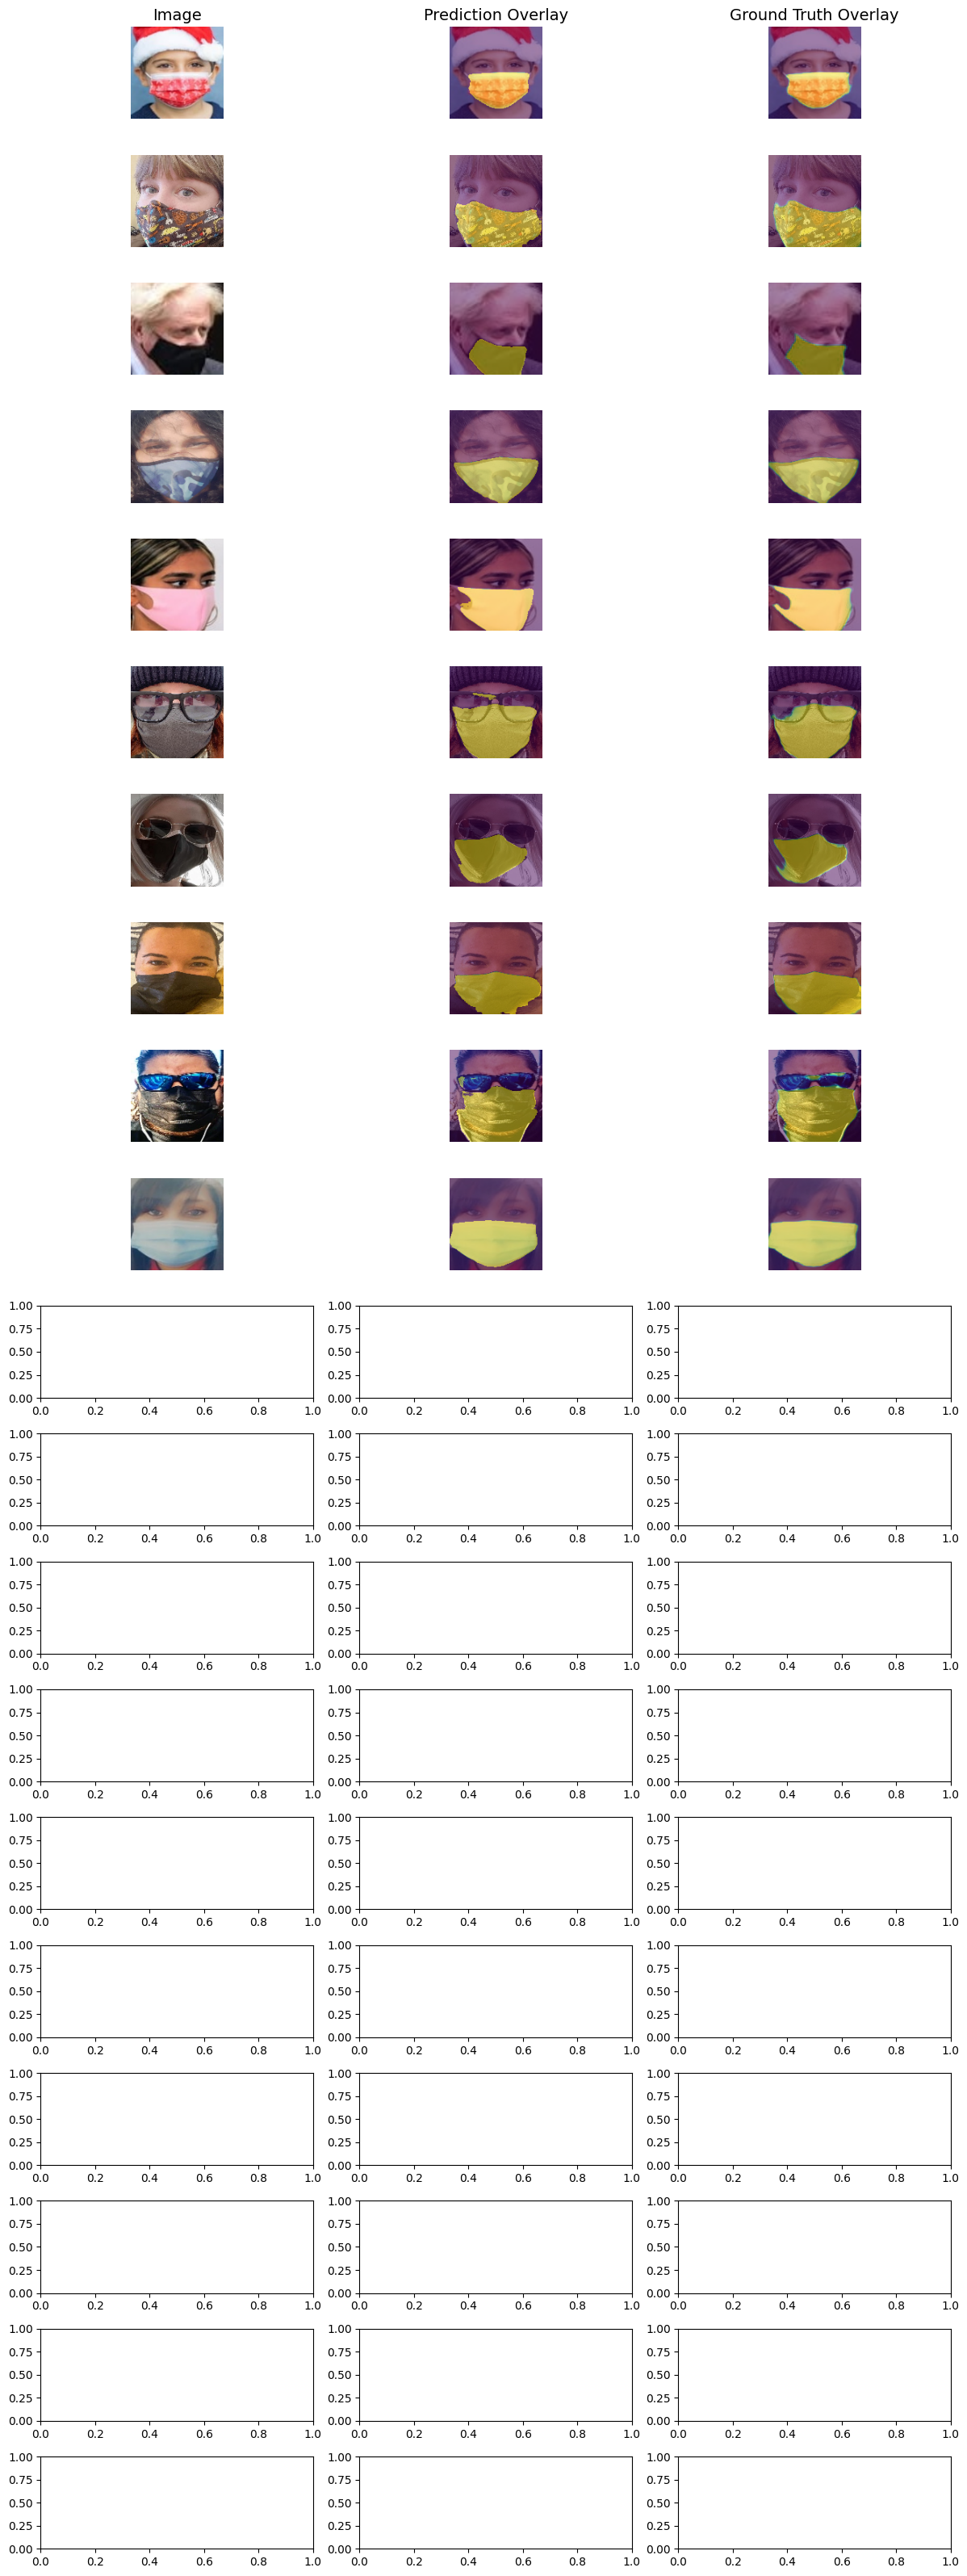

In [16]:
def image_show(model, val_dataset, mean=[0.53, 0.457, 0.43], std=[0.257, 0.239, 0.231]):
    # Get one batch of images and segmentations
    for imgs, segs in val_dataset.take(1):
        pass  # imgs, segs now hold the first batch

    # Make predictions
    preds = model(imgs, training=False)
    preds = tf.argmax(preds, axis=-1)  # Convert to class indices

    # Denormalize images
    mean_tensor = tf.constant(mean, dtype=tf.float32)
    std_tensor = tf.constant(std, dtype=tf.float32)
    imgs = imgs * std_tensor + mean_tensor  # Re-scale images

    imgs = imgs.numpy()  # Convert to NumPy arrays for visualization
    segs = segs.numpy()
    preds = preds.numpy()

    fig, axs = plt.subplots(20, 3, figsize=(12, 32))
    column_titles = ["Image", "Prediction Overlay", "Ground Truth Overlay"]

    for ax, title in zip(axs[0], column_titles):
        ax.set_title(title, fontsize=14)

    for i in range(10):
        # Image
        axs[i, 0].imshow(imgs[i])
        axs[i, 0].axis('off')

        # Overlay prediction mask
        axs[i, 1].imshow(imgs[i])
        axs[i, 1].imshow(preds[i], cmap='viridis', alpha=0.5)
        axs[i, 1].axis('off')

        # Overlay ground truth mask
        axs[i, 2].imshow(imgs[i])
        axs[i, 2].imshow(segs[i], cmap='viridis', alpha=0.5)
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
train_model(model, optimizer, loss_fn, train_loader, val_loader, num_epochs=2)
image_show(model, val_loader)
